# File descriptions

- donations.csv - contains information about the donations to each project. This is only provided for projects in the training set.
- essays.csv - contains project text posted by the teachers. This is provided for both the training and test set.
- projects.csv - contains information about each project. This is provided for both the training and test set.
- resources.csv - contains information about the resources requested for each project. This is provided for both the training and test set.
- outcomes.csv - contains information about the outcomes of projects in the training set.
- sampleSubmission.csv - contains the project ids of the test set and shows the submission format for the competition.

# Data science for social goods - Submission from Shao Ying (Clare) Huang

Date: March 11, 2017

In [1]:
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
%matplotlib inline

donations = pd.read_csv("donations.csv")
essays = pd.read_csv("essays.csv")
projects = pd.read_csv("projects.csv")
resources = pd.read_csv("resources.csv")
# outcomes = pd.read_csv("outcomes.csv")

## Step 0: Exploring the _outcomes_ file

### Data cleaning: 
- Replace all NaN in 'True/False' column as 'False'. Then, map {'f','t'} to {0,1}.
- Combining the last three features (three_or_more_non_teacher_referred_donors, one_non_teacher_referred_donor_giving_100_plus, donation_from_thoughtful_donor) into one (one_in_three)

### Defining the scope this project:
- Given the time limit to complete the task, I would narrow down the scope of this mini-project to prediction of the most criterion determining whether the project 'is_exciting'.
- From the **estimation of importance via logistic regression** below, we see that the two most crucial criteria are: (1) great_chat and (2) at_least_1_teacher_referred_donor.
- However, whether 'great_chat' is fulfilled is high sensitive to the threshold of great_messages_proportion set (here it is 62%) in the definition of 'great_chat'.
- Therefore, in this mini-project, I would define the research questions as: **predicting the likelyhood of project having 'at least one teacher-acquired donor'**.


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier

outcomes = pd.read_csv("outcomes.csv")
outcomes.fillna(value='f',axis=0,inplace=True)
outcomes.replace(to_replace=['f','t'], value=[0,1], axis=0, inplace=True)
outcomes['one_in_three'] = (outcomes.three_or_more_non_teacher_referred_donors + outcomes.one_non_teacher_referred_donor_giving_100_plus + \
outcomes.donation_from_thoughtful_donor >= 1) * 1

features = ["at_least_1_teacher_referred_donor","fully_funded","at_least_1_green_donation","great_chat","one_in_three"]

print(features)
outcomes_to_fit = outcomes[features]
outcomes_to_fit

m = LogisticRegression()
m.fit(outcomes_to_fit, outcomes['is_exciting'])
print('==============Logistic Regression==============')
print(m.coef_)

m2 = ExtraTreesClassifier()
m2.fit(outcomes_to_fit, outcomes['is_exciting'])
print('==============Extra Trees Classifier==============')
print(m2.feature_importances_)

m3 = GradientBoostingClassifier()
m3.fit(outcomes_to_fit, outcomes['is_exciting'])
print('==============Gradient Boosting Classifier==============')
print(m3.feature_importances_)

/home/csyhuang/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/generic.py:3416: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warn('the "axis" argument is deprecated and will be removed in'


['at_least_1_teacher_referred_donor', 'fully_funded', 'at_least_1_green_donation', 'great_chat', 'one_in_three']
==============Logistic Regression==============
[[ 12.33506169   9.21487012   7.41694208  11.90242625   9.28252151]]
==============Extra Trees Classifier==============
[ 0.40157366  0.09200133  0.02573986  0.3690198   0.11166534]
==============Gradient Boosting Classifier==============
[ 0.28227579  0.09469497  0.04475445  0.42960757  0.14866723]


## Exploratory analysis

Describe the dataset using counts, averages, frequency tabeles, and plots. Do you see anything interesting or potentially problematic?

### Proportion of projects with at least 1 teacher-referred donor

Observation: Approximately 1/5 of the projects fulfill this criterion.

0    494666
1    124660
Name: at_least_1_teacher_referred_donor, dtype: int64


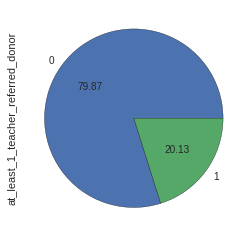

In [3]:
outcomes['at_least_1_teacher_referred_donor'].value_counts().plot.pie(figsize=(4, 4),autopct='%.2f')
print outcomes['at_least_1_teacher_referred_donor'].value_counts()

In [17]:
projects_with_outcome = projects.merge(outcomes[['projectid','at_least_1_teacher_referred_donor']], how='inner')
project_with_teacher_referred = projects_with_outcome[projects_with_outcome.at_least_1_teacher_referred_donor==1]
project_no_teacher_referred = projects_with_outcome[projects_with_outcome.at_least_1_teacher_referred_donor==0]
# print projects_with_outcome.columns
projects_with_outcome.head()
projects_with_outcome.columns
projects_with_outcome['school_state'].replace(to_replace='La', value='LA', inplace=True)
# projects_with_outcome[projects_with_outcome['school_state']=='La']['school_state']='LA'

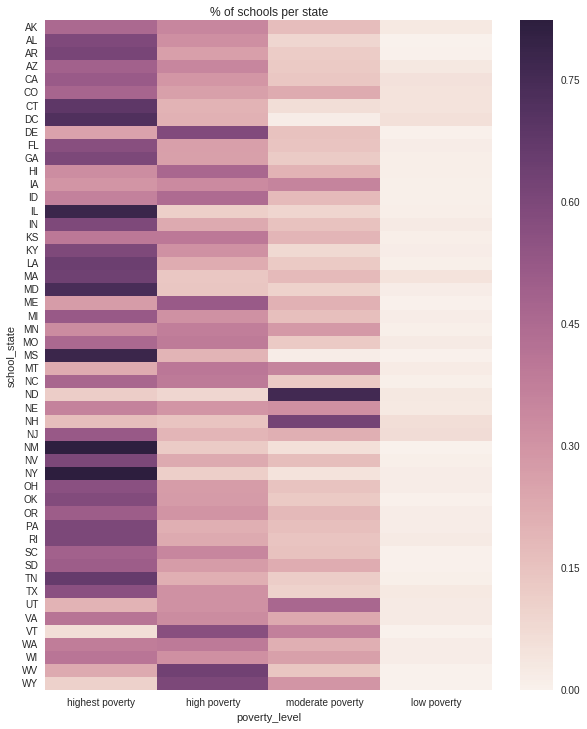

In [18]:
import seaborn as sns
projects_with_outcome[['school_state','poverty_level']].groupby('school_state').count()
# projects_with_outcome2[['school_state','poverty_level']].groupby('school_state').sum()
poverty_table = pd.crosstab(projects_with_outcome['school_state'],projects_with_outcome['poverty_level'],normalize='index')\
[['highest poverty','high poverty','moderate poverty','low poverty']]

plt.figure(figsize=(10,12))
plt.title('% of schools per state')
ax = sns.heatmap(poverty_table)

### Geographical distribution of number of projects and successful rate
- The plots below show: 
    (top) (log of) total number of projects, and 
    (bottom) % of successful projects (i.e. with at least 1 donor referred by teacher)

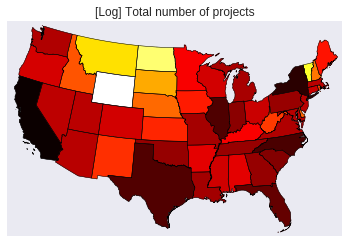

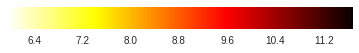

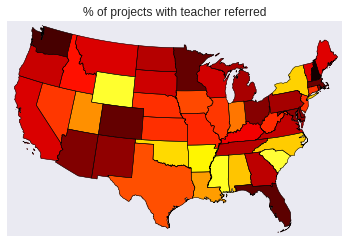

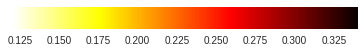

In [19]:
from utility_plot_density_map import *

## Is there state dependence of outcomes?
state_stat_of_outcomes = pd.concat([project_with_teacher_referred['school_state'].value_counts() ,\
                      project_no_teacher_referred['school_state'].value_counts()], axis=1, join='inner')
state_stat_of_outcomes.columns = ['with_teacher_referred','no_teacher_referred']
state_stat_of_outcomes['total'] = state_stat_of_outcomes['with_teacher_referred']+state_stat_of_outcomes['no_teacher_referred']
state_stat_of_outcomes['with_teacher_referred_percent'] = state_stat_of_outcomes['with_teacher_referred']/state_stat_of_outcomes['total']
state_stat_of_outcomes['no_teacher_referred_percent'] = state_stat_of_outcomes['no_teacher_referred']/state_stat_of_outcomes['total']
state_stat_of_outcomes['state_short'] = state_stat_of_outcomes.index
state_stat_of_outcomes['state_long'] = state_stat_of_outcomes['state_short'].apply(lambda x: states_list[x])

state_stat_of_outcomes.set_index(['state_long'], inplace=True)
vmin2,vmax2 = log(state_stat_of_outcomes['total'].min()), log(state_stat_of_outcomes['total'].max())
Plot_density_map( state_stat_of_outcomes['total'].apply(lambda x: log(x)).to_dict() ,'[Log] Total number of projects',vmin2,vmax2)
plt.show()

# plt.show()
# pl.savefig("colorbar.pdf")
vmin,vmax = log(state_stat_of_outcomes['with_teacher_referred_percent'].min()), log(state_stat_of_outcomes['with_teacher_referred_percent'].max())
Plot_density_map( state_stat_of_outcomes['with_teacher_referred_percent'].to_dict() ,'% of projects with teacher referred',0.12,0.34)
plt.show()


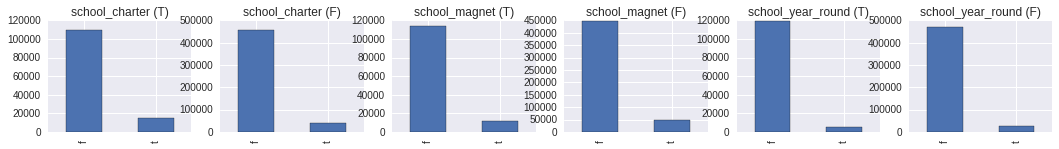

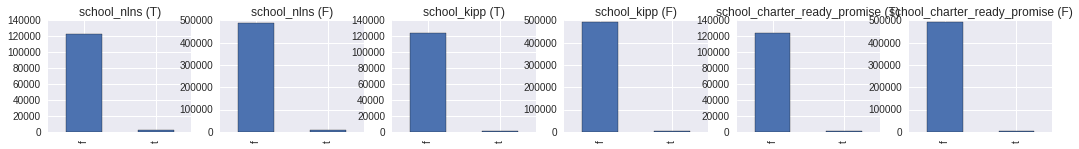

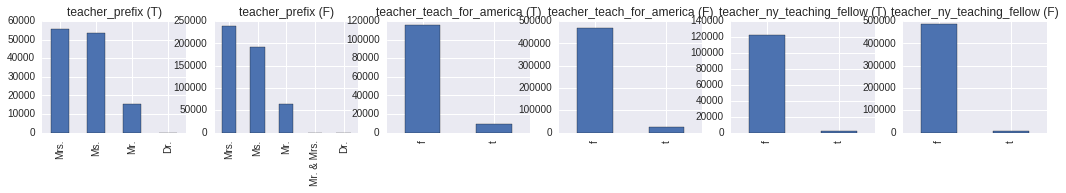

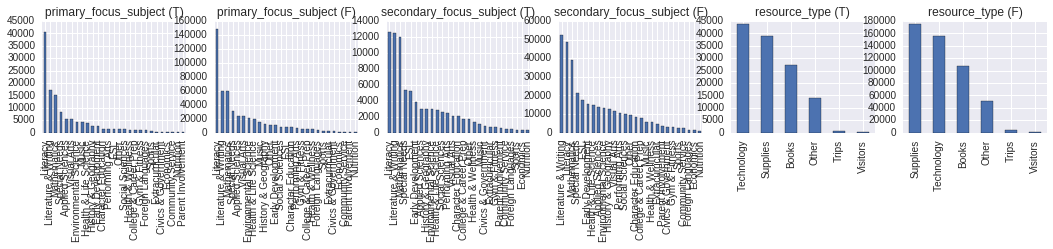

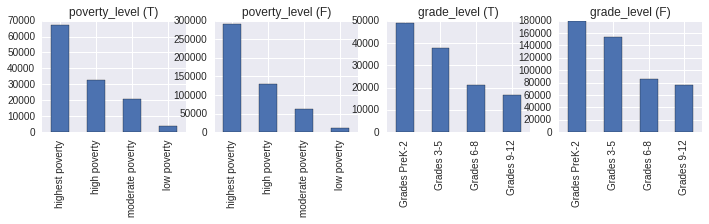

In [20]:
# print projects_with_outcome.columns
even_col = 0
for col in [u'school_charter', u'school_magnet',
       u'school_year_round', u'school_nlns', u'school_kipp',
       u'school_charter_ready_promise', u'teacher_prefix',u'teacher_teach_for_america', 
       u'teacher_ny_teaching_fellow',u'primary_focus_subject',u'secondary_focus_subject',u'resource_type',
       u'poverty_level', u'grade_level']:
    aa = project_with_teacher_referred[col].value_counts()
    bb = project_no_teacher_referred[col].value_counts()
    
    if even_col%3 == 0:
        plt.subplots(figsize=(18,2))
        first,second = 161,162
    elif even_col%3 == 1:
        first,second = 163,164
    else:
        first,second = 165,166
    
    plt.subplot(first)
    plt.title(col+' (T)')    
    aa.plot.bar()
    plt.subplot(second)
    plt.title(col+' (F)')    
    bb.plot.bar()
            
    even_col += 1       


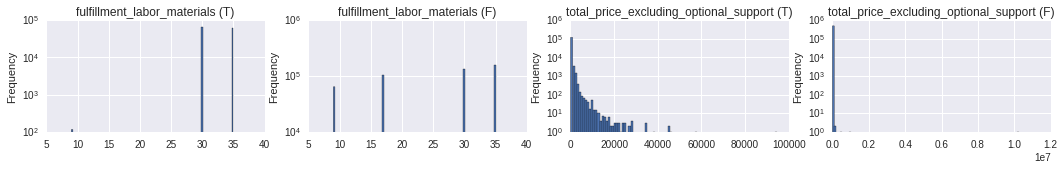

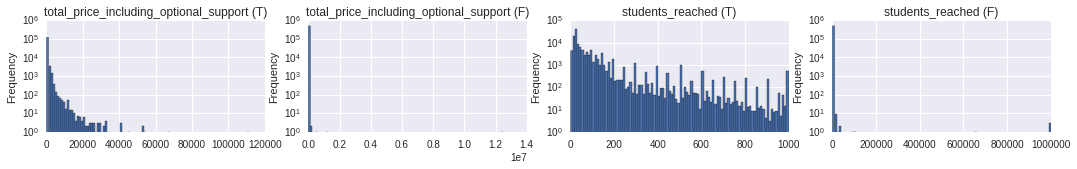

In [21]:
# Numerical variables    
even_col = 0
for col in ['fulfillment_labor_materials', u'total_price_excluding_optional_support',
       u'total_price_including_optional_support', u'students_reached']:
    aa = project_with_teacher_referred[col]
    bb = project_no_teacher_referred[col]
    
    if even_col%2 == 0:
        plt.subplots(figsize=(18,2))
        first,second = 141,142
    elif even_col%2 == 1:
        first,second = 143,144
    
    try:
        plt.subplot(first)
        plt.title(col+' (T)')
        aa.plot(kind='hist',logy=True,bins=100)
        axis1 = plt.gca()
        #xx = axis1.get_xlim()
        plt.subplot(second)
        plt.title(col+' (F)')    
        bb.plot(kind='hist',logy=True,bins=100)
        #axis2 = plt.gca()
        #axis2.set_xlim(xx*2)
    except:
        print col+' is not suitable for histogram'
    even_col += 1


# Modeling
Task: (For those applying for machine learning positions). Build (and validate) a model with the data that predicts a quantity of interest (fully funded for example), identifies underlying structure in the data, or explores a potentially important relationship among fields in the dataset. What did you learn from it? Why is it potentially useful or relevant to someone's decision making?

### Some observations from the EDA
From the EDA above, 

But note that secondary subject is undefined for 10% of data.
### Rows containing Nan values:
- projectid                                     0
- at_least_1_teacher_referred_donor             0
- teacher_prefix                                0
- primary_focus_subject                        36
- grade_level                                   7
- fulfillment_labor_materials               35082
- total_price_excluding_optional_support        0
- total_price_including_optional_support        0
- students_reached                            144

In [27]:
# print projects_with_outcome.columns
# substituting categorical names with number
def map_categorical_to_numbers(data,col):
    aa = data[col].value_counts()
    #print aa
    map_dict = dict()
    for item,xx in zip(aa.index,np.arange(1,aa.size+1)):
        map_dict[item] = xx
    #print map_dict
    return map_dict
    
simple_model_datasets = projects_with_outcome[['school_metro','school_state','teacher_prefix','at_least_1_teacher_referred_donor','primary_focus_subject','secondary_focus_subject',\
                                               'grade_level','fulfillment_labor_materials', 'total_price_excluding_optional_support',\
                                               'total_price_including_optional_support','students_reached','resource_type',\
                                                'school_year_round', 'school_nlns', 'school_kipp']]
# simple_model_outcome = projects_with_outcome[['projectid','at_least_1_teacher_referred_donor']]

simple_model_datasets.head()
for col in ['school_metro','school_state','teacher_prefix','primary_focus_subject','secondary_focus_subject','grade_level',\
            'resource_type','school_year_round', 'school_nlns', 'school_kipp']:
    mapping_dict = map_categorical_to_numbers(simple_model_datasets,col)
    simple_model_datasets[col].replace(mapping_dict,inplace=True)
    
simple_model_datasets.secondary_focus_subject.fillna(0,inplace=True)
simple_model_datasets.isnull().sum()
simple_model_datasets.dropna(axis=0, how='any',inplace=True)
# display(simple_model_datasets.head())



/home/csyhuang/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score

for test_size_inc in [0.1,0.15,0.2,0.25,0.3]:
    X = simple_model_datasets.drop('at_least_1_teacher_referred_donor', axis=1)
    y = simple_model_datasets.at_least_1_teacher_referred_donor
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_inc, random_state=42)

    clf = RandomForestClassifier(n_estimators=10)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print 'Test size='+str(test_size_inc)
    print 'True Positive:'
    print sum((y_pred==1) & (y_test.values==1))
    print 'True Negative:'
    print sum((y_pred==0) & (y_test.values==0))
    print 'False Positive:'
    print sum((y_pred==1) & (y_test.values==0))
    print 'False Negative:'
    print sum((y_pred==0) & (y_test.values==1))
    print 'Accuracy = (TP+TN)/Total'
    print float(sum((y_pred==0) & (y_test.values==0))+sum((y_pred==1) & (y_test.values==1)))/float(y_pred.size)
    print '============================================'


Test size=0.1
True Positive:
1526
True Negative:
37910
False Positive:
2338
False Negative:
9416
Accuracy = (TP+TN)/Total
0.770384840789
Test size=0.15
True Positive:
2306
True Negative:
56821
False Positive:
3513
False Negative:
14145
Accuracy = (TP+TN)/Total
0.770033209611
Test size=0.2
True Positive:
2922
True Negative:
75795
False Positive:
4598
False Negative:
19065
Accuracy = (TP+TN)/Total
0.768870873217
Test size=0.25
True Positive:
3749
True Negative:
94818
False Positive:
5691
False Negative:
23716
Accuracy = (TP+TN)/Total
0.770211136637
Test size=0.3
True Positive:
4474
True Negative:
113959
False Positive:
6701
False Negative:
28435
Accuracy = (TP+TN)/Total
0.771203823688


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier


for test_size_inc in [0.1,0.15,0.2,0.25,0.3]:
    X = simple_model_datasets.drop('at_least_1_teacher_referred_donor', axis=1)
    y = simple_model_datasets.at_least_1_teacher_referred_donor
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_inc, random_state=42)

    clf = GradientBoostingClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print 'Test size='+str(test_size_inc)
    print 'True Positive:'
    print sum((y_pred==1) & (y_test.values==1))
    print 'True Negative:'
    print sum((y_pred==0) & (y_test.values==0))
    print 'False Positive:'
    print sum((y_pred==1) & (y_test.values==0))
    print 'False Negative:'
    print sum((y_pred==0) & (y_test.values==1))
    print 'Accuracy = (TP+TN)/Total'
    print float(sum((y_pred==0) & (y_test.values==0))+sum((y_pred==1) & (y_test.values==1)))/float(y_pred.size)
    print '============================================'


Test size=0.1
True Positive:
4
True Negative:
40248
False Positive:
0
False Negative:
10938
Accuracy = (TP+TN)/Total
0.78632545419
Test size=0.15
True Positive:
9
True Negative:
60330
False Positive:
4
False Negative:
16442
Accuracy = (TP+TN)/Total
0.785817542489
Test size=0.2
True Positive:
11
True Negative:
80389
False Positive:
4
False Negative:
21976
Accuracy = (TP+TN)/Total
0.785309630787
Test size=0.25
True Positive:
21
True Negative:
100498
False Positive:
11
False Negative:
27444
Accuracy = (TP+TN)/Total
0.785464234923
Test size=0.3
True Positive:
15
True Negative:
120652
False Positive:
8
False Negative:
32894
Accuracy = (TP+TN)/Total
0.785751030481


# A Data Story
Find a specific interesting case in the data and tell us what happens with it. Provide evidence from the data that supports your narrative.

# Questions for the Project Partner
What questions would you ask the partner now that you have seen the data? What is missing that you might need to get from them or other data sources to do something useful with the data?

Save your notebook and commit it with an informative message, then push the commit to your repository on github.